# keras-rl で深層強化学習入門

## 深層強化学習とは？



## keras-rl とは？
 [Karlsruhe Institute of Technology](http://www.kit.edu/) (カールスルーエ工科大学， KIT) の人たちがつくった keras っぽく深層強化学習が使える python package． 
 
 Kerasをベースにしている．
 
[keras-rl @ github](https://github.com/matthiasplappert/keras-rl)

### 特徴
* Pros
    * 使いやすい！ （Kerasのようなインターフェイス， OpenAI Gymに準拠）
    * 様々な深層強化学習のアルゴリズムが利用できる
    * Keras でモデルを作ってそのまま渡せる
* Cons
    * まだドキュメント化が不十分
    
### サポートするアルゴリズム
#### 離散行動（出力が離散的値．right, left, up,..）
* Deep Q Learning (DQN)
* Double DQN
* Cross-Entropy Method (CEM)
* Dueling network DQN (Dueling DQN)

#### 連続行動（出力が連続ベクトル）
* Deep Deterministic Policy Gradient (DDPG)
* Continuous DQN (CDQN or NAF)

## パッケージのインストール
atari-py
gym
h5py0
ipython
Keras
keras-rl
matplotlib
Pillow
PyOpenGL
seaborn

これらが入っていないようなら， 

pip install -r requirements.txt 

を実行してください！

In [1]:
# 数値計算に必須のもろもろ
import numpy as np

# 可視化パッケージ 
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

# seaborn を入れてない人は以下をコメントアウト
import seaborn as sns
sns.set_style('darkgrid')

## Gym で環境の導入

In [2]:
# OpenAI Gym
import gym

# 離散行動の環境を指定 （後でDQNをつかうため）
ENV_NAME ='CartPole-v0'
#ENV_NAME ='Acrobot-v0'

# 環境の初期化
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)

# インターフェイスの情報をもらっておく
nb_actions = env.action_space.n
input_shape = (1,) + env.observation_space.shape

print("# of Actions : {}".format(nb_actions))
print("Shape of Observation : {}".format(env.observation_space.shape))

[2017-02-21 12:16:39,862] Making new env: CartPole-v0


# of Actions : 2
Shape of Observation : (4,)


# Keras の Sequential Model でネットワークを作成
訓練に使うネットワークをKerasのSequential model として作成します．

入力がObservationの次元数，出力が離散行動の数（nb_actions）のネットワークを作成します．
<img src="images/network.png">

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 深層（笑）パーセプトロン
model = Sequential()
model.add(Flatten(input_shape=input_shape))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_1 (Flatten)              (None, 4)             0           flatten_input_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 50)            250         flatten_1[0][0]                  
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 50)            0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 2)             102         activation_1[0][0]               
___________________________________________________________________________________________

# Deep Q Network エージェントの作成
Deep Q Network （DQN） エージェントを作成します．

DQNエージェントは Replay Buffer と呼ばれる，これまでの環境との相互作用データを残しておきます（SequentialMemory）．

Episode の結果だけを使う場合，結果だけを残すEpisodeParameterMemoryもあります．この形のメモリはCross Entropy Method 内で使われています．

In [4]:
# Deep Reinforcement Learning: keras-rl
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor

# Optimizer
from keras.optimizers import Adam

# メモリーバッファーをつくる
memory = SequentialMemory(limit=1000, window_length=1)

# 方策をつくる
#policy = BoltzmannQPolicy(tau=1.0)
policy =EpsGreedyQPolicy(eps=0.1)

# Reward の大きさをスケーリング
class RewardProcessor(Processor):
    def process_reward(self, reward):
        return reward / 1.
processor = RewardProcessor()

# Deep Q Network をつくる
dqn = DQNAgent(model=model,
               gamma = 0.95,
               nb_actions=nb_actions,
               memory=memory,
               nb_steps_warmup=10,
               target_model_update=1e-2,
               policy=policy,
               processor=processor)

# Optimizer を設定
optimizer = Adam(lr=1e-3, epsilon=0.0001)

#  dqn エージェントの作成
# MAE: mean_absolute_error でエラー表示
dqn.compile(optimizer=optimizer, metrics=['mae'])

## 可視化用のcallback を定義
callback　関数を定義して，plotでの可視化を導入します．

callback（rl.callbacks）はkerasの [CallBack](https://keras.io/ja/callbacks/#_2) を拡張したもので，強化学習に関するデータがlogsに追加されています．

（ただし，validation dataが無いので使えないcallbackもある）

今回はこれでパフォーマンスの可視化をします．

In [5]:
from rl.callbacks import Callback, ModelIntervalCheckpoint

class PlotReward(Callback):
    def on_train_begin(self, episode, logs={}):
        self.episode_reward = []
        self.fig = plt.figure(0)

    def on_episode_end(self, episode, logs={}):
        self.episode_reward.append(logs['episode_reward'])
        self.show_result()

    def show_result(self):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.clf()
        plt.plot(self.episode_reward, 'r')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.pause(0.001)

callbacks = [PlotReward(), ModelIntervalCheckpoint(filepath='./weight_now.h5f', interval=1000)]

# 実際に学習サイクルを回します

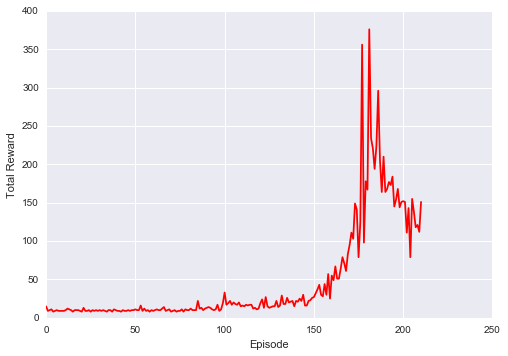

10000/10000 [==============================] - 264s - reward: 1.0000   
done, took 264.752 seconds


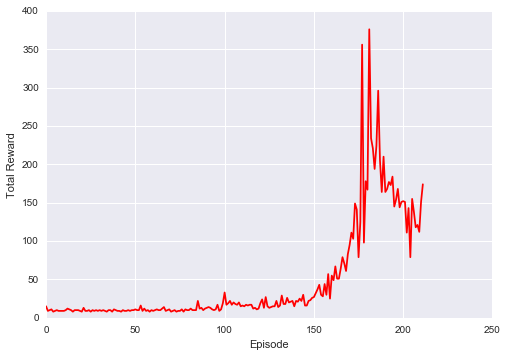

In [6]:
# 学習
dqn.fit(env, nb_steps=10000, visualize=True, callbacks=callbacks, nb_max_episode_steps=1000)

# 学習後， 環境を消す
env.close()

# 5 Episode分だけネットワークを固定してテストしてみます

In [7]:
dqn.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=1000)

Testing for 5 episodes ...
Episode 1: reward: 154.000, steps: 154
Episode 2: reward: 173.000, steps: 173
Episode 3: reward: 169.000, steps: 169
Episode 4: reward: 180.000, steps: 180
Episode 5: reward: 190.000, steps: 190


# 学習されたモデルを保存します

In [8]:
# モデルのweight の保存
#dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# モデルをそのまま保存
dqn.model.save('mymdel.h5f', overwrite=True)

# 保存したモデルを読み込んで，再び試してみます
保存したモデルを load して，同じ環境で動かしてみます．

学習済みのモデルを保存しておけば，訓練せずに後から使えます．

In [10]:
from keras.models import load_model

# 前のモデルを一旦消す
del model

# 学習したモデルをLoad
model = load_model('mymdel.h5f')

# observationから行動を取ってくる関数
policy = BoltzmannQPolicy()
def get_action(observation):
    q_values = model.predict(observation)
    return policy.select_action(q_values[0])


# 同じ環境を新たに作って試す
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)

# 1Episode だけ試して終了
done = False
observation = env.reset()
while not done:
    action = get_action(observation.reshape(1,1,4))
    observation, reward, done, info = env.step(action)
    env.render()
    
env.close()

[2017-02-21 12:27:44,552] Making new env: CartPole-v0
